# TNE 2: Principal Component Analysis

The purpose of this tutorial is to use Principal Component Analysis (PCA) 
for dimension reduction applied to images.


In [23]:
from pylab import *
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from numpy import linalg as la

%pylab inline
pylab.rcParams['figure.figsize'] = (15, 8)
from ipywidgets import interact, widgets

Populating the interactive namespace from numpy and matplotlib


/home/kronert/anaconda3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['linalg', 'power', 'fft', 'info', 'random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


## 1. Application: handwritten digits recognition 5 & 6
We load 2 matrices which contain each a sequence of examples of 16x16 images of handwritten digits which are 5 and 6 here. Each line of the matrix contains 256 pixel values coding for the gray level of a 16x16 image.

In [2]:
train_5 = np.loadtxt('train_5.txt',delimiter=',')   # 556 samples
train_6 = np.loadtxt('train_6.txt',delimiter=',')   # 664 samples

#### Examples of images:

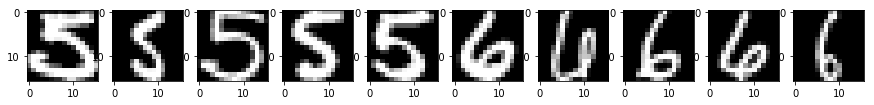

In [11]:
for n in range (5):
    I = np.reshape(train_5[n,:],(16,16))
    plt.subplot(1,10,n+1)
    plt.imshow(I,cmap='gray')

    
for n in range (5):
    I = np.reshape(train_6[n,:],(16,16))
    plt.subplot(1,10,n+6)
    plt.imshow(I,cmap='gray')


#### Separating the training and test sets

We keep in the training set the 145 first images of 5s and the 200 first
images of 6s:

In [12]:
x_train_brut = np.vstack((train_5[:145,:], train_6[:200,:]))
N_train = np.size(x_train_brut,axis=0)
class_train = np.ones((345,1))   # label 1 for digit 6
class_train[:145] = 0       # label 0 for digit 5

x_test_brut = np.vstack((train_5[145:,:], train_6[200:,:]))
N_test = np.size(train_5,axis=0)+np.size(train_6,axis=0)-N_train
class_test = np.ones((N_test,1))
class_test[:(556-145)] = 0


## 2. Principal Component Analysis

The purpose of this part is to observe the respective contributions of
each component of a PCA of images of 5. The function `sklearn.decomposition.PCA` of `scikit-learn` is available. In practice, one must first estimate the mean vector and then work with centered data. 

### Documentation
First have a look at
http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html
    

In [13]:
# Principal component analysis
moy_train = x_train_brut.mean(axis=0)  # all the data, 5 & 6
x_train_centre = x_train_brut-np.tile(moy_train,(N_train,1))
print(x_train_centre.shape)
# PCA from scikit-learn
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(x_train_centre)  # you may forget centering that is done by sklearn PCA

singval = pca.singular_values_   # eigenvalues
comp = pca.components_           # principal components
proj = pca.transform(x_train_centre)  # computes the projection coefficients
print(comp.shape)

(345, 256)
(256, 256)


### Display the averaged images of 5 & 6 respectively

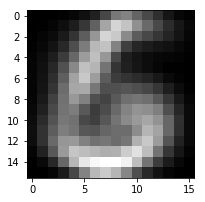

In [14]:
I_moy = np.reshape(moy_train,(16,16))   # averaged image = mean 
plt.figure(figsize=(3,5))
plt.imshow(I_moy,cmap = 'gray')
plt.show()

### Display an example rebuilt from the 1st component only

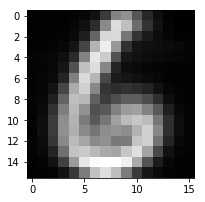

In [15]:
n=12   # choice of image no n=12 or any other
plt.figure(figsize=(3,5))
I = I_moy + proj[n,0]*np.reshape(comp[0,:],(16,16))# adding the 1st PCA component 
plt.imshow(I,cmap='gray')
plt.show()

### Exercise 1: PCA & approximation

1. Read the documentation of function `PCA` and identify the input and output parameters.
2. Implement a progressive reconstruction of an image of digit 5 by adding the successive 
contribution of principal components.
3. Observe graphical results. How many components are necessary to obtain a 
reconstruction that you may consider as acceptable? nice? very nice?
4. Optional question: do the same for 6.


###### Function tools

In [28]:
def projected_images (x_train_brut, N_comp):
    """ 
    Returns a projected image on the first N_comp with PCA
    - x_train_brut : raw training data
    - N_comp : number of components of PCA we want to project our image
    
    
    Returns:
    - array of size (N_train,16,16) images reconstructed with the first N_comp of pca
    """
    pca = PCA(n_components=N_comp,
              copy=True, whiten=False, svd_solver='auto',
              tol=0.0, iterated_power='auto',
              random_state=None)
    
    N_train = x_train_brut.shape[0]
    moy_train = x_train_brut.mean(axis=0)
    x_train_centre = x_train_brut-moy_train
    
    pca.fit(x_train_centre)
    
    first_N_comp = pca.components_     # principal components
    first_N_coeff = pca.transform(x_train_centre)  # computes the projection coefficients
    
    images = (first_N_coeff.dot(first_N_comp)+moy_train).reshape((N_train,16,16))
    
    return images

def one_projection(num, nb_comp, comp=comp, proj=proj):
    """
    Returns a projected image on the first N_comp with PCA, as the componants and coefficients
    are already been computed
        - num : the number of the image in the dataset
        - nb_comp : number of PCA componant we want to project on
        - comp : an array of all PCA componants, computed in a previous step
        - proj : coefficient of all projected images in the principal componants
    
    Returns :
        - array : represent the projected image"""
    return  I_moy + (proj[num,:nb_comp+1].dot(comp[:nb_comp+1,:])).reshape((16,16))


###### Reconstructed images

In [30]:
# We use ipywidget interact objet to explore the differents images, with differents componants
choiceNbComp = widgets.IntSlider(value=1,min=0,max=250,step=1,continous_update=False)
choiceNum    = widgets.IntSlider(value=12,min=0,max=N_train,step=1)

@interact(nb_comp = choiceNbComp, num = choiceNum)
def reconstruct(nb_comp, num):
    plt.subplot(121)
    plt.imshow(x_train_brut[num].reshape((16,16)),cmap='gray')
    plt.title("Image Originale")
    plt.subplot(122)
    # Compute the image projection
    plt.title(f"Image Projetée({nb_comp})")
    I = one_projection(num, nb_comp)
    return plt.imshow(I,cmap='gray')

interactive(children=(IntSlider(value=1, description='nb_comp', max=250), IntSlider(value=12, description='num…

Text(0.5,1,'original')

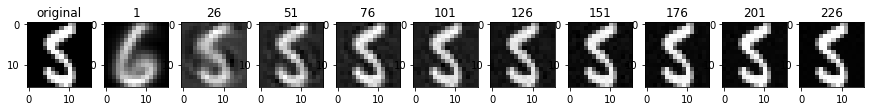

In [31]:
# Digits 5
index_ex=1
nb_display = 10
interval_comp = np.floor(x_train_brut.shape[1]/nb_display)

for n in range(nb_display):
    plt.subplot(1,nb_display+1,n+2)
    N_comp = (n*interval_comp+1)
    plt.imshow(projected_images(x_train_brut,int(N_comp))[index_ex,:,:],cmap='gray')
    plt.title(int(N_comp))

plt.subplot(1,nb_display+1,1)    
plt.imshow(x_train_brut[index_ex].reshape((16,16)),cmap="gray")
plt.title("original")
  

Text(0.5,1,'original')

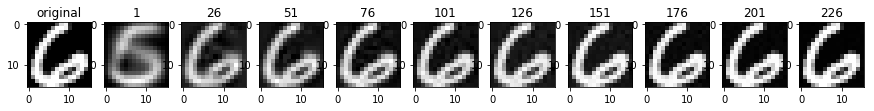

In [18]:
# Digits 6
index_ex=210
nb_display = 10
interval_comp = np.floor(x_train_brut.shape[1]/nb_display)

for n in range(nb_display):
    plt.subplot(1,nb_display+1,n+2)
    N_comp = (n*interval_comp+1)
    plt.imshow(projected_images(x_train_brut,int(N_comp))[index_ex,:,:],cmap='gray')
    plt.title(int(N_comp))

plt.subplot(1,nb_display+1,1)    
plt.imshow(x_train_brut[index_ex].reshape((16,16)),cmap="gray")
plt.title("original")
  

We can consider the picture : 
- acceptable when there are approximately more than 50 components
- nice : >100
- very nice: >150
<br> PCA reduces dimensionality very efficiently!

### Exercise 2: PCA & classification
1. Use `proj[0:2,:]` as the coordinates of a point representing each sample
of the training set in a plane. Display the cloud of points associated to
digits 5 and 6 by using 2 different colors.
2. Comment on the repartition of points in the plane. 
3. Do you see how this PCA step makes possible the use of a much simpler classification? 
What would you propose as an alternative to logistic regression of TP3 then?


(345, 256)


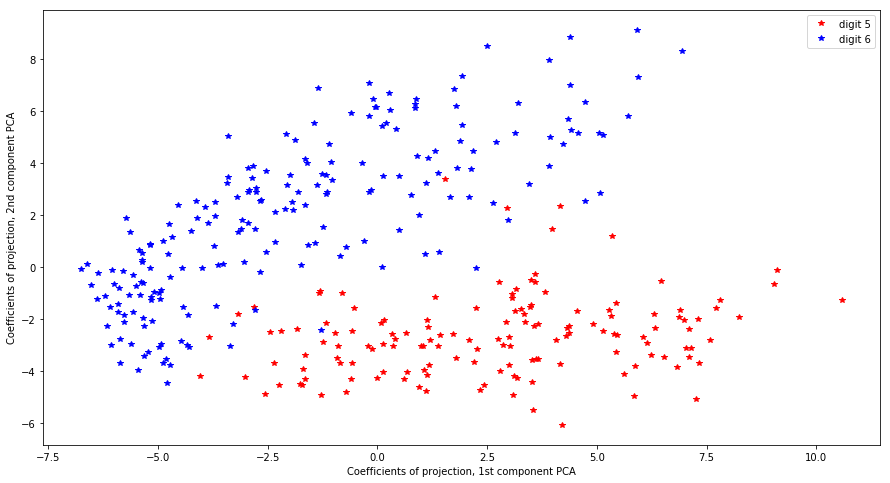

In [19]:
# Exercise 2
print(proj.shape)
plt.plot(proj[:145,0],proj[:145,1],"r*",label="digit 5")
plt.plot(proj[145:,0],proj[145:,1],"b*",label = "digit 6")
plt.xlabel("Coefficients of projection, 1st component PCA")
plt.ylabel("Coefficients of projection, 2nd component PCA")
plt.legend()

By only taking the first 2 components, we can already classify digits 5 and 6 quite well. Therefore, instead of using logistic regression on all features, we could only keep the first two components as our traininig data.

/home/kronert/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Score train set : 0.9594202898550724
Score test set : 0.832


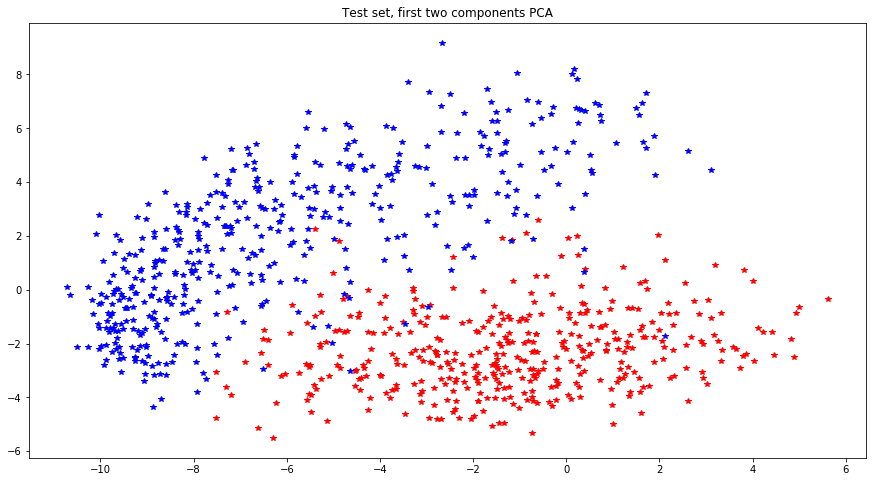

In [20]:
## We only keep the first 2 components of PCA of the training set
x_train_pca = proj[:,:2]

## We only keep the first 2 components of PCA of the test set
x_test_pca = np.dot(comp,x_test_brut.T) # compute the PCA components of test set
x_test_pca = (x_test_pca[:2,:]).T # keep the first 2 components

## plot points test set (first 2 components)
plt.plot(x_test_pca[:(556-145),0],x_test_pca[:(556-145),1], 'r*')
plt.plot(x_test_pca[(556-145):,0],x_test_pca[(556-145):,1], 'b*')
plt.title ("Test set, first two components PCA")

## Logistic regression with only the first 2 components
LR = LogisticRegression()
LR.fit(x_train_pca,class_train)

print("Score train set :",LR.score(x_train_pca,class_train))
print("Score test set :",LR.score(x_test_pca,class_test))

To improve the model, and choose the best number of PCA componants, we could use cross validation

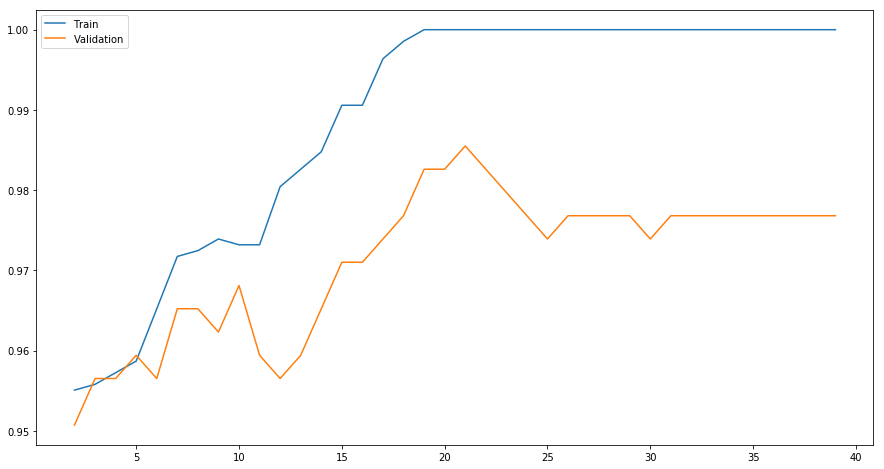

In [37]:
def cross_val(K=5):
    # Nombre de fold de la cross validation
    # Nombre de données total pour les classes 5 et 6
    N_5 = 145
    N_6 = 200
    # nombre de données des classes 5 et 6 par fold
    size_5 = N_5//K
    size_6 = N_6//K
    # Recueil les erreurs moyennes
    moyennes_train = []
    moyennes_validation  = []
    # on fait varier le nombre de paramètre de la PCA
    nb_comp_list = range(2,40)
    for nb_comp in nb_comp_list:
        # Recueil les erreurs pour un écart type maximal égal à max_std
        error_train = []
        error_validation = []
        for i in range(K):

            # Ensemble d'entrainement (on doit récupérer chez les 5 et chez les 6)
            # les 145 premiers élément sont des 5 les suivants sont des 6
            x_train = np.vstack((x_train_brut[:i*size_5,:], x_train_brut[(i+1)*size_5:N_5,:],
                                 x_train_brut[N_5 :N_5 + i*size_6,:], x_train_brut[N_5 + (i+1)*size_6 :,:]))
            # Labels
            train_labels   = np.ones(N_5 + N_6 - size_5 - size_6)
            train_labels[:N_5-size_5] = 0
            # Ensemble de validation
            x_vald = np.vstack((x_train_brut[i*size_5:(i+1)*size_5,:],
                                 x_train_brut[N_5 + i*size_6:N_5 + (i+1)*size_6 ,:]))
            # labels associés
            vald_labels = np.ones(size_5 + size_6)
            vald_labels[:size_5] = 0
            
            # On effectue la pca
            pca = PCA(n_components=nb_comp)
            x_train_pca =pca.fit_transform(x_train)
            x_vald_pca = pca.transform(x_vald)
            
            # On effectue la régression logistique
            LR = LogisticRegression()
            LR.fit(x_train_pca,train_labels)


            # On enregistre les données
            error_train.append(LR.score(x_train_pca,train_labels))
            error_validation.append(LR.score(x_vald_pca,vald_labels))
        
        # On calcul la moyenne
        moyennes_train.append(np.mean(error_train))
        moyennes_validation.append(np.mean(error_validation))
    # On affiche le résultat
    plot(nb_comp_list, moyennes_train, label = "Train")
    plot(nb_comp_list, moyennes_validation, label = "Validation")
    legend()
cross_val()

Acording to the cross validation, the best hyperpameter for the PCA, is n_components = 20


In [47]:
# We compute the Logistic Regression the a 20 PCA's components
x_train_pca = proj[:,:20]

x_test_pca = pca.transform(x_test_brut)[:,:20]



## Logistic regression with only the first 20 components
LR = LogisticRegression()
LR.fit(x_train_pca,class_train)

print("Score train set :",LR.score(x_train_pca,class_train))
print("Score test set :",LR.score(x_test_pca,class_test))

Score train set : 0.9971014492753624
Score test set : 0.8571428571428571


/home/kronert/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


## Beyond this lab

Have a look at other examples of applications, like

http://scikit-learn.org/stable/auto_examples/decomposition/plot_faces_decomposition.html#sphx-glr-auto-examples-decomposition-plot-faces-decomposition-py
    